In [1]:
import pickle
import random

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.express as px

import tensorflow as tf

import umap
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import hdbscan

2023-11-17 14:02:44.982594: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-17 14:02:45.067971: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-17 14:02:45.068018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-17 14:02:45.070272: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-17 14:02:45.079469: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-17 14:02:45.080460: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Load the data about embeddings, labels and predictions

In [4]:
with open('data/yamnet_scores/yamnet_scores_2020.pickle', 'rb') as file:
    pred_scores_20 = pickle.load(file)

with open('data/yamnet_scores/yamnet_scores_2021.pickle', 'rb') as file:
    pred_scores_21 = pickle.load(file)

pred_score_* are dictionaries {filename: (prediction, embedding, spectrogram)}

In [5]:
[el.shape for el in list(pred_scores_20.values())[0]], [el.shape for el in list(pred_scores_21.values())[0]]

([TensorShape([63, 521]), TensorShape([63, 1024]), TensorShape([3072, 64])],
 [TensorShape([60, 521]), TensorShape([60, 1024]), TensorShape([2928, 64])])

prediction are shape (n_frames, n_classes), each element is the "probability" of the occurrence of the corresponding event (to the index)

embeddings are (n_frames, embedding_dim)

Load the real labels

In [6]:
df_20 = pd.read_csv('data/yamnet_foreground_labels_20.csv')
df_21 = pd.read_csv('data/yamnet_foreground_labels_21.csv')
df_20.head()

,file,frame_number,label_0,label_1,label_2,predicted_label
0,fu_2jeb5yktarbeiyk.wav,3,Nature/Animals/Bird,None,None,Environmental noise
1,fu_2jeb5yktarbeiyk.wav,4,Nature/Animals/Bird,None,None,Environmental noise
2,fu_2jeb5yktarbeiyk.wav,5,Nature/Animals/Bird,None,None,Environmental noise
3,fu_2jeb5yktarbeiyk.wav,6,Nature/Animals/Bird,None,None,Animal
4,fu_2jeb5yktarbeiyk.wav,7,Nature/Animals/Bird,None,None,Animal


In [7]:
real_classes_20 = np.unique(df_20[[col for col in df_20.columns if 'label_' in col]].values)
real_classes_21 = np.unique(df_21[[col for col in df_21.columns if 'label_' in col]].values)

real_classes = np.union1d(real_classes_20, real_classes_21)
real_classes

array(['Human/Cough', 'Human/Movement', 'Human/Movement/Steps',
       'Human/Music', 'Human/Voice', 'Industrial/Construction',
       'Industrial/Industry', 'Industrial/Vacuum',
       'Industrial/Ventilation', 'Nature/Animals', 'Nature/Animals/Bird',
       'Nature/Animals/Cat', 'Nature/Animals/Dog',
       'Nature/Elements/Water', 'Nature/Elements/Wind',
       'Nature/Vegetation', 'Noise', 'None', 'Nothing', 'Signals',
       'Signals/Alarm', 'Signals/Bells', 'Signals/Klaxon',
       'Signals/Siren', 'Things/Ball', 'Things/Blind', 'Things/Door',
       'Things/Movement', 'Things/Trolley', 'Transport/Motorized',
       'Transport/Motorized/Air', 'Transport/Motorized/Rail',
       'Transport/Motorized/Road', 'Transport/Non-motorized'],
      dtype=object)

In [8]:
real_classes = [el for el in real_classes if el != 'None']
real_classes

['Human/Cough',
 'Human/Movement',
 'Human/Movement/Steps',
 'Human/Music',
 'Human/Voice',
 'Industrial/Construction',
 'Industrial/Industry',
 'Industrial/Vacuum',
 'Industrial/Ventilation',
 'Nature/Animals',
 'Nature/Animals/Bird',
 'Nature/Animals/Cat',
 'Nature/Animals/Dog',
 'Nature/Elements/Water',
 'Nature/Elements/Wind',
 'Nature/Vegetation',
 'Noise',
 'Nothing',
 'Signals',
 'Signals/Alarm',
 'Signals/Bells',
 'Signals/Klaxon',
 'Signals/Siren',
 'Things/Ball',
 'Things/Blind',
 'Things/Door',
 'Things/Movement',
 'Things/Trolley',
 'Transport/Motorized',
 'Transport/Motorized/Air',
 'Transport/Motorized/Rail',
 'Transport/Motorized/Road',
 'Transport/Non-motorized']

In [9]:
x_list, y_list, y_list_one_hot = [], [], []

for i, row in df_20.iterrows():
    filename = row['file']
    frame_n = row['frame_number']
    label_names = [row[lab] for lab in row.keys() if 'label_' in lab if row[lab] != 'None']

    x_list.append(pred_scores_20[filename][1][frame_n]) # embeddings are in the second position
    # this for statified folding
    lab_0 = 'Nothing' if len(label_names) == 0 else label_names[0]
    y_list.append(tf.constant(real_classes.index(lab_0)))
    # we must use one-hot encoding
    n_classes = len(real_classes)
    y_arr = np.zeros(n_classes)
    if len(label_names) == 0:
      y_arr[real_classes.index('Nothing')] = 1
    for lab in label_names:
        y_arr[real_classes.index(lab)] = 1
    y_list_one_hot.append(tf.constant(y_arr))

for i, row in df_21.iterrows():
    filename = row['file']
    frame_n = row['frame_number']
    label_names = [row[lab] for lab in row.keys() if 'label_' in lab if row[lab] != 'None']

    x_list.append(pred_scores_21[filename][1][frame_n]) # embeddings are in the second position
    # this for statified folding
    lab_0 = 'Nothing' if len(label_names) == 0 else label_names[0]
    y_list.append(tf.constant(real_classes.index(lab_0)))
    # we must use one-hot encoding
    n_classes = len(real_classes)
    y_arr = np.zeros(n_classes)
    if len(label_names) == 0:
      y_arr[real_classes.index('Nothing')] = 1
    for lab in label_names:
        y_arr[real_classes.index(lab)] = 1
    y_list_one_hot.append(tf.constant(y_arr))

len(x_list), len(y_list), len(y_list_one_hot)

(28690, 28690, 28690)

In [10]:
x_arr = np.array([el.numpy() for el in x_list])
y_arr = np.array([el.numpy() for el in y_list])
x_arr.shape, y_arr.shape

((28690, 1024), (28690,))

# Dimensionality reduction

In [11]:
reducer = umap.UMAP()
# x_arr is numpy array of embeddings
reduced_emb = reducer.fit_transform(x_arr)
reduced_emb

array([[ 0.4506051 , 10.641221  ],
       [ 0.45885903, 10.150245  ],
       [ 0.47798043, 10.233827  ],
       ...,
       [-2.2808976 ,  7.259335  ],
       [-2.6986167 ,  7.197169  ],
       [-3.9182408 ,  6.336457  ]], dtype=float32)

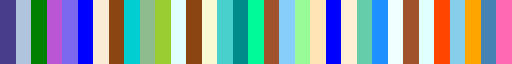

In [12]:
random.seed(3)
cmap = mpl.colors.ListedColormap(random.choices(list(mpl.colors.CSS4_COLORS.keys()), k=len(real_classes)))
cmap

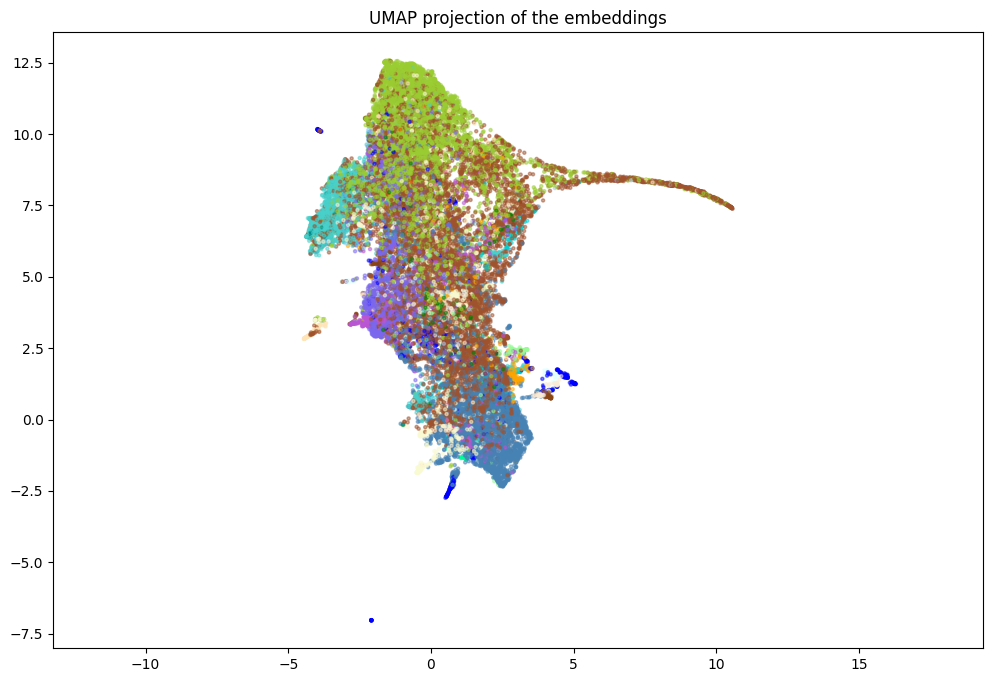

In [13]:
plt.figure(figsize=(12, 8))
plt.scatter(
    reduced_emb[:, 0],
    reduced_emb[:, 1],
    alpha=0.5, s=5, c=[cmap(el) for el in y_arr],
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the embeddings')
plt.show()

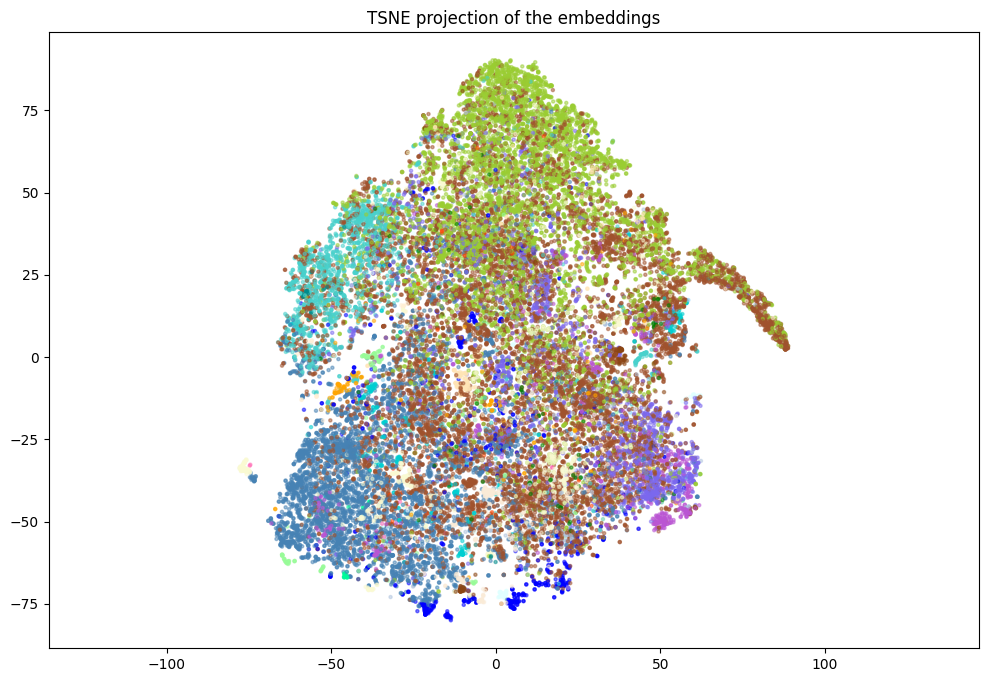

In [14]:
reducer = TSNE(perplexity=50)
# x_arr is numpy array of embeddings
reduced_emb = reducer.fit_transform(x_arr)

plt.figure(figsize=(12, 8))
plt.scatter(
    reduced_emb[:, 0],
    reduced_emb[:, 1],
    alpha=0.5, s=5, c=[cmap(el) for el in y_arr],
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('TSNE projection of the embeddings')
plt.show()

# Unsupervised

Maybe I can try clustering (after having reduced dimensionality), and check labels distributions within each cluster, just to check if embeddings do represent well our labels (since an ML model is not really learning much)

In [15]:
n_features = 15
reducer = umap.UMAP(n_components=n_features)
reduced_emb = reducer.fit_transform(x_arr)

Trying 10 clusters
Trying 20 clusters
Trying 30 clusters
Trying 40 clusters


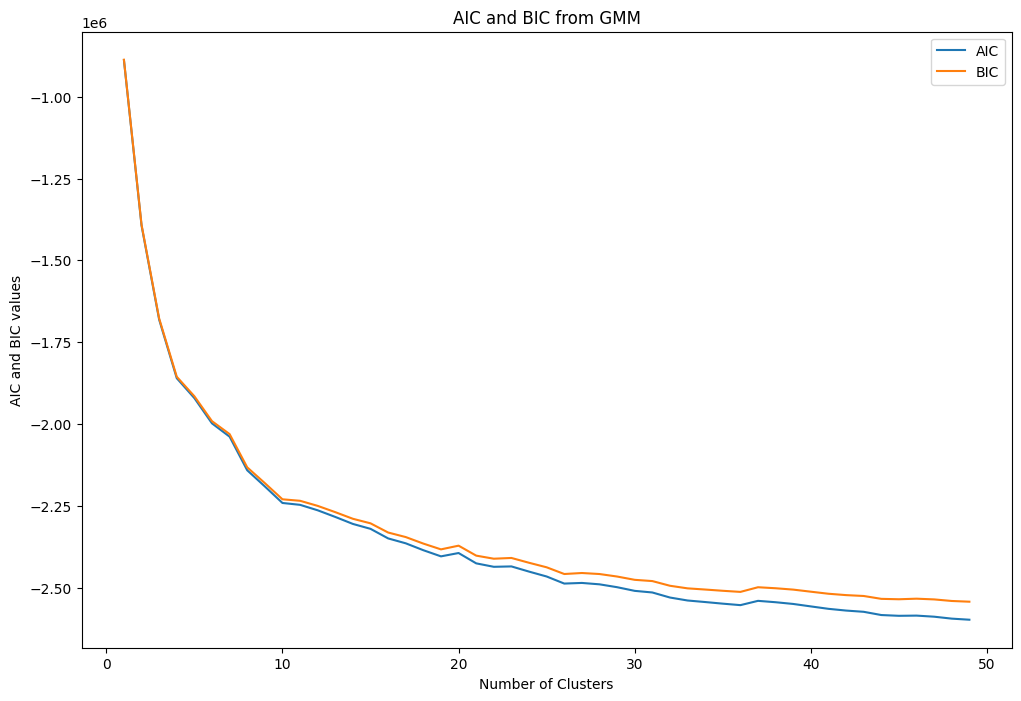

In [16]:
# Create empty lists for AIC and BIC values
min_n = 1
max_n = 50
aic_score = []
bic_score = []
# Loop through different number of clusters
for i in range(1, max_n):
  if i % 10 == 0:
    print(f'Trying {i} clusters')
  # Create Gaussian Mixture Model
  gmm = GaussianMixture(n_components=i, random_state=0).fit(reduced_emb)
  # Get AIC score for the model
  aic_score.append(gmm.aic(reduced_emb))
  # Get BIC score for the model
  bic_score.append(gmm.bic(reduced_emb))
# Visualization
plt.figure(figsize=(12,8))
plt.plot(range(1, max_n), aic_score, label='AIC')
plt.plot(range(1, max_n), bic_score, label='BIC')
plt.legend(loc='best')
plt.title('AIC and BIC from GMM')
plt.xlabel('Number of Clusters')
plt.ylabel('AIC and BIC values')
plt.show()

In [17]:
n_clusters = len(real_classes)
kmeans = KMeans(n_clusters=n_clusters, n_init='auto').fit(reduced_emb)
kmeans.inertia_

15954.0703125

In [18]:
cluster_df = pd.DataFrame(data=np.stack((kmeans.labels_, y_arr), axis=1), columns=['cluster', 'label_index'])
cluster_df.groupby(by='cluster').size()

cluster
0      891
1     1209
2      985
3     1252
4      375
5     1273
6      905
7      769
8     1180
9      526
10    1370
11    1079
12    1015
13    1030
14     583
15    1186
16    1174
17     831
18     748
19     923
20    1085
21     456
22    1305
23     336
24     154
25    1010
26     239
27    1398
28     873
29     725
30    1011
31       8
32     786
dtype: int64

In [19]:
grouped_clust = cluster_df.groupby(by=['cluster', 'label_index']).size()
grouped_clust

cluster  label_index
0        2                2
         3                6
         4               39
         5               15
         6                1
                       ... 
32       27               3
         28              10
         30               1
         31             318
         32               4
Length: 550, dtype: int64

In [20]:
hdb = hdbscan.HDBSCAN(min_cluster_size=10)
hdb.fit(reduced_emb)
hdb_cluster_df = pd.DataFrame(data=np.stack((hdb.labels_, y_arr), axis=1), columns=['cluster', 'label_index'])
hdb_cluster_df.groupby(by='cluster').size()

cluster
-1      19282
 0         37
 1         20
 2         81
 3         21
        ...  
 228       24
 229       13
 230       31
 231       11
 232       57
Length: 234, dtype: int64

In [21]:
hdb_grouped_clust = hdb_cluster_df.groupby(by=['cluster', 'label_index']).size()
hdb_grouped_clust

cluster  label_index
-1       0                 5
         1               100
         2                66
         3               320
         4              1284
                        ... 
 230     31                1
 231     10               11
 232     10               53
         14                1
         17                3
Length: 1017, dtype: int64